In [3]:
import time
import pandas as pd
import os
import numpy as np
import snapatac2_scooby as sp
import scanpy as sc
import anndata as ad
import glob

import scipy.sparse
import tqdm

Important:
* SnapATAC automatically deletes reads that have the same start end and UMI (duplicates)
* If you do not provide UMI identifier (umi_regex or umi_tag) it will delete all reads that have the same start/end (not ideal)

## Read in RNA bam files

In [9]:
data_path = '/s/project/QNA/scborzoi/submission_data'

In [10]:
adata = sc.read(os.path.join(data_path, 'data', "metacells_imputed.h5ad"), gex_only=False)

In [12]:
sample_map =  {
    "49": "1", 
    "50": "2", 
    "51": "3", 
    "52": "4",
    "53": "5", 
    "54": "6", 
    "55": "7",
    "MUC26775": "1",
    "MUC26776": "2",
    "MUC26777": "3",
    "MUC26778": "4",
    "MUC26779": "5",
    "MUC26780": "6",
    "MUC26781": "7"
}

In [13]:
adata.obs['sample_rna'] = adata.obs_names.str.split('_').str[-1]
adata.obs['barcode_rna'] = adata.obs_names.str.split('-').str[0] + '-1'

In [15]:
adata.obs['sample_atac'] = adata.obs['atac_barcode'].str.split('-').str[-1]
adata.obs['barcode_atac'] = adata.obs['atac_barcode'].str.split('-').str[0] + '-1'

### Make Fragment files RNA

In [7]:
sample_files = glob.glob(os.path.join(data_path , 'nov2024/scRNA_Anna_ref_2020', '*', 'outs', '*bam'))

In [ ]:
for sample_file in tqdm.tqdm(sample_files):
    print(sample_file)
    sample = sample_file.split('/')[-3]
    print(sample)
    out_path = os.path.join(data_path, 'nov2024', 'snapatac', 'fragments')
    outfile = os.path.join(out_path, f'{sample}.fragments.bed.gz')
    sample_number = sample_map[sample]
    whitelist = adata.obs.query("sample_rna == @sample_number")['barcode_rna'].to_list()
    
    print(sample_number)
    if (len(whitelist)>0) & (~os.path.exists(os.path.join(out_path, f'{sample}.fragments.bed.minus.gz'))):
        sp.pp.make_fragment_file(
            sample_file, 
            output_file=outfile,
            barcode_tag="CB", 
            umi_tag="UB",
            umi_regex=None, 
            stranded=True, 
            is_paired=False, 
            shift_left=0, 
            shift_right=0,
            xf_filter=True
        )


    for strand in ['plus', 'minus']:
        if not os.path.exists(os.path.join(data_path, 'nov2024',  'snapatac', 'anndata', f'snapatac_{sample}_{strand}.h5ad')):
            test = sp.pp.import_data(
                    f"{out_path}/{sample}.fragments.bed.{strand}.gz", 
                    chrom_sizes=sp.genome.hg38, 
                    min_num_fragments=0, 
                    n_jobs=-1,
                    whitelist=whitelist
                )
            if not test.obs_names.isin(whitelist).all():
                print(sample)
                break

            test.obs.index = test.obs.index + '_' + sample_number
                
            test.X = scipy.sparse.csr_matrix((test.obsm['fragment_single'].shape[0], 0))
            test.write(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', f'snapatac_{sample}_{strand}.h5ad'))
    else:
        print(f"Skipping {sample}")

  0%|          | 0/7 [00:00<?, ?it/s]

/data/ceph/hdd/project/node_07/moretti_epicardiods/nov2024/scRNA_Anna_ref_2020/MUC26781/outs/possorted_genome_bam.bam
MUC26781
7
Skipping MUC26781
/data/ceph/hdd/project/node_07/moretti_epicardiods/nov2024/scRNA_Anna_ref_2020/MUC26777/outs/possorted_genome_bam.bam
MUC26777
3


 29%|██▊       | 2/7 [42:08<1:45:22, 1264.42s/it]

Skipping MUC26777
/data/ceph/hdd/project/node_07/moretti_epicardiods/nov2024/scRNA_Anna_ref_2020/MUC26778/outs/possorted_genome_bam.bam
MUC26778
4


 43%|████▎     | 3/7 [1:24:42<2:00:07, 1801.78s/it]

Skipping MUC26778
/data/ceph/hdd/project/node_07/moretti_epicardiods/nov2024/scRNA_Anna_ref_2020/MUC26775/outs/possorted_genome_bam.bam
MUC26775
1


 57%|█████▋    | 4/7 [2:07:35<1:44:28, 2089.34s/it]

Skipping MUC26775
/data/ceph/hdd/project/node_07/moretti_epicardiods/nov2024/scRNA_Anna_ref_2020/MUC26776/outs/possorted_genome_bam.bam
MUC26776
2


 71%|███████▏  | 5/7 [2:49:10<1:14:20, 2230.36s/it]

Skipping MUC26776
/data/ceph/hdd/project/node_07/moretti_epicardiods/nov2024/scRNA_Anna_ref_2020/MUC26780/outs/possorted_genome_bam.bam
MUC26780
6


 86%|████████▌ | 6/7 [3:23:17<36:09, 2169.61s/it]  

## Combine both samples

In [22]:
import anndata

In [23]:
samples =  [sample_file.split('/')[-3] for sample_file in sample_files]

In [25]:
for strand in ['plus', 'minus']:
    print(strand)
    adatas = [
        os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', f'snapatac_{sample}_{strand}.h5ad') 
     for sample in samples
    ]

    anndata.experimental.concat_on_disk(
        in_files=adatas, 
        out_file=os.path.join(data_path,'nov2024',  'snapatac','anndata', f'snapatac_merged_{strand}.h5ad'),
        uns_merge='unique'
    )

    # uns merge is not working, add that

    adata_cov = sc.read_h5ad(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', f'snapatac_merged_{strand}.h5ad'))

    test = sc.read(adatas[0])

    adata_cov.uns = test.uns.copy()

    # join obs
    adata_cov.obs = adata_cov.obs.join(adata.obs)
    adata_cov.write(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', f'snapatac_merged_{strand}.h5ad'))

plus


... storing 'sample_rna' as categorical
... storing 'barcode_rna' as categorical


minus


... storing 'sample_rna' as categorical
... storing 'barcode_rna' as categorical


## Read in ATAC fragment files

In [34]:
sample_files = glob.glob(os.path.join(data_path , 'nov2024/scATAC_Anna_ref_2020', '*', '*.tsv.gz'))

In [41]:
sample_prefix = "MUC266"

In [44]:
for sample_file in tqdm.tqdm(sample_files):
    print(sample_file)
    sample = sample_file.split('/')[-2]
    print(sample)
    sample_number = sample_map[sample]
    sample = sample_prefix + sample 
    whitelist = adata.obs.query("sample_atac == @sample_number")['barcode_atac'].to_list()
    
    print(sample_number)
    if not os.path.exists(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', f'snapatac_{sample}_atac.h5ad')):
        test = sp.pp.import_data(
                sample_file, 
                chrom_sizes=sp.genome.hg38, 
                min_num_fragments=0, 
                n_jobs=-1,
                whitelist=whitelist,
                sorted_by_barcode=False
            )
        if not test.obs_names.isin(whitelist).all():
            print(sample)
            break

        test.obs.index = test.obs.index.str.split('-1').str[0] + '-' + sample_number

        test.X = scipy.sparse.csr_matrix((test.obsm['fragment_paired'].shape[0], 0))
        test.write(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', f'snapatac_{sample}_atac.h5ad'))
    else:
        print(f"Skipping {sample}")

  0%|          | 0/7 [00:00<?, ?it/s]

/data/ceph/hdd/project/node_07/moretti_epicardiods/nov2024/scATAC_Anna_ref_2020/53/fragments.tsv.gz
53
5


 14%|█▍        | 1/7 [01:26<08:41, 86.93s/it]

/data/ceph/hdd/project/node_07/moretti_epicardiods/nov2024/scATAC_Anna_ref_2020/52/fragments.tsv.gz
52
4


 29%|██▊       | 2/7 [04:39<12:26, 149.31s/it]

/data/ceph/hdd/project/node_07/moretti_epicardiods/nov2024/scATAC_Anna_ref_2020/55/fragments.tsv.gz
55
7


 43%|████▎     | 3/7 [06:32<08:50, 132.74s/it]

/data/ceph/hdd/project/node_07/moretti_epicardiods/nov2024/scATAC_Anna_ref_2020/50/fragments.tsv.gz
50
2


 57%|█████▋    | 4/7 [11:04<09:22, 187.49s/it]

/data/ceph/hdd/project/node_07/moretti_epicardiods/nov2024/scATAC_Anna_ref_2020/51/fragments.tsv.gz
51
3


 71%|███████▏  | 5/7 [15:54<07:28, 224.40s/it]

/data/ceph/hdd/project/node_07/moretti_epicardiods/nov2024/scATAC_Anna_ref_2020/54/fragments.tsv.gz
54
6
/data/ceph/hdd/project/node_07/moretti_epicardiods/nov2024/scATAC_Anna_ref_2020/49/fragments.tsv.gz
49
1


100%|██████████| 7/7 [23:55<00:00, 205.07s/it]


In [45]:
samples = [sample_prefix + sample_file.split('/')[-2] for sample_file in sample_files]

In [47]:
    
adatas = [
    os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', f'snapatac_{sample}_atac.h5ad') 
 for sample in samples
]

anndata.experimental.concat_on_disk(
    in_files=adatas, 
    out_file=os.path.join(data_path, 'nov2024', 'snapatac','anndata', f'snapatac_merged_atac.h5ad'),
    uns_merge='unique'
)

# uns merge is not working, add that

adata_cov = sc.read_h5ad(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', f'snapatac_merged_atac.h5ad'))

test = sc.read(adatas[0])

adata_cov.uns = test.uns.copy()

adata_cov.write(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', f'snapatac_merged_atac.h5ad'))

## Save insertions

In [52]:
adata_cov = sc.read(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', f'snapatac_merged_atac.h5ad'))

In [53]:
sp.pp.fragments_to_insertions(adata_cov)

In [55]:
adata_cov.obsm.pop('fragment_paired')

<23808x3088286401 sparse matrix of type '<class 'numpy.uint32'>'
	with 450072459 stored elements in Compressed Sparse Row format>

In [56]:
adata_cov.write(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', 'snapatac_merged_atac.h5ad'))

## Save only cells with ATAC match

In [18]:
barcodes_with_match = adata.obs_names[adata.obs['atac_match'] == 1]

In [19]:
atac_barcodes = adata[barcodes_with_match].obs['atac_barcode'].tolist()

In [9]:
adata_plus = sc.read(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', 'snapatac_merged_plus.h5ad'))
adata_minus = sc.read(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', 'snapatac_merged_minus.h5ad'))
adata_atac = sc.read(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', 'snapatac_merged_atac.h5ad'))

In [23]:
adata_plus = adata_plus[barcodes_with_match]
adata_minus = adata_minus[barcodes_with_match]

In [24]:
adata_plus

View of AnnData object with n_obs × n_vars = 30638 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'clusters', 'day', 'tech', 'atac_match', 'atac_barcode', 'leiden_res0.3', 'leiden_res0.5', 'leiden_res0.8', 'leiden_res1', 'MAB21L2_act', 'HAND1_act', 'MEF2C_act', 'GATA4_act', 'ISL1_act', 'FOS_act', 'sample_rna', 'barcode_rna'
    uns: 'reference_sequences'
    obsm: 'fragment_single'

In [25]:
adata_minus

View of AnnData object with n_obs × n_vars = 30638 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'clusters', 'day', 'tech', 'atac_match', 'atac_barcode', 'leiden_res0.3', 'leiden_res0.5', 'leiden_res0.8', 'leiden_res1', 'MAB21L2_act', 'HAND1_act', 'MEF2C_act', 'GATA4_act', 'ISL1_act', 'FOS_act', 'sample_rna', 'barcode_rna'
    uns: 'reference_sequences'
    obsm: 'fragment_single'

In [31]:
adata_atac = adata_atac[atac_barcodes]

In [33]:
adata_atac.obs = adata_atac.obs.reset_index()
adata_atac.obs.index = adata_plus.obs.index

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [35]:
adata_plus.write(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', 'snapatac_matched_plus.h5ad'))
adata_minus.write(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', 'snapatac_matched_minus.h5ad'))
adata_atac.write(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', 'snapatac_matched_atac.h5ad'))

... storing 'index' as categorical


In [20]:
adata = adata[barcodes_with_match]

In [22]:
adata.write(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', 'adata_matched.h5ad'))

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'sample_rna' as categorical
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'barcode_rna' as categorical
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'sample_atac' as categorical
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initi

## Write out no_neighbors

In [23]:
adata_plus = sc.read(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', 'snapatac_matched_plus.h5ad'))

In [24]:
empty_csr = scipy.sparse.csr_matrix((adata_plus.shape[0], adata_plus.shape[0]))
scipy.sparse.save_npz(os.path.join(data_path, 'nov2024', "hooby_training_data", "no_neighbors.npz"), empty_csr)

## Write out embedding

In [25]:
embedding = pd.DataFrame({
    'embedding':list(adata.obsm['X_glue'].astype(np.single)),
    'obs_names': adata.obs.index
})

embedding.to_parquet(os.path.join(data_path, 'nov2024', "hooby_training_data", "embedding.pq"))



## Write out cell type index

In [27]:
cellindex = [
    {'celltype': cell_type, 
     'cellindex': list(np.where(adata.obs['leiden_res1'] == cell_type)[0])} for cell_type in adata.obs.leiden_res1.unique()
]
pd.DataFrame(cellindex).to_parquet(os.path.join(data_path, 'nov2024', "hooby_training_data", 'celltype.pq'))

## Write pseudobulks RNA

In [ ]:
for strand in ['plus', 'minus']:
    adata_cov = sc.read(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', f'snapatac_matched_{strand}.h5ad'))
    sp.ex.export_coverage(
        adata_cov, 
        groupby='leiden_res1', 
        bin_size=1, 
        out_dir=os.path.join(data_path, 'nov2024','snapatac',"pseudobulks"), 
        normalization=None,
        n_jobs=-1,
        max_frag_length=None,
        suffix='.bw',
        prefix=f"{strand}."
    )

2024-12-04 19:32:30 - INFO - Exporting fragments...


## Write out DEG sequences

In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np

In [4]:
adata = sc.read(os.path.join(data_path, 'nov2024', 'snapatac', 'anndata', 'adata_matched.h5ad'))

In [5]:
adata.X = adata.layers['counts'].copy()

In [6]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [7]:
adata.var.index = adata.var['gene_id'].str.split('.').str[0]

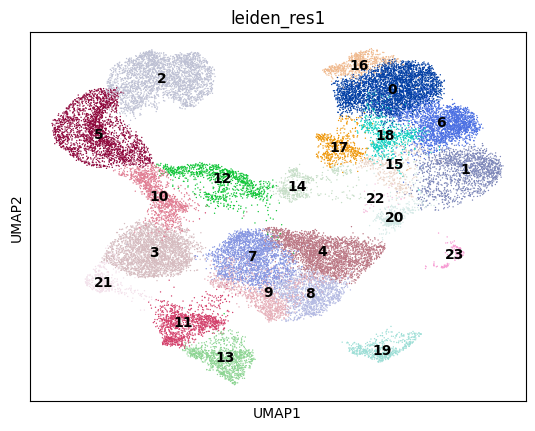

In [8]:
sc.pl.umap(adata, color='leiden_res1', legend_loc='on data')

In [9]:
def get_head_and_tail(adata, ct):
    df = sc.get.rank_genes_groups_df(adata, ct)
    df = df[(np.abs(df['logfoldchanges']) > 2) & (df['pvals_adj'] < 0.01)]
    return df#pd.concat([df.head(100), df.tail(100)])

In [11]:
sc.tl.rank_genes_groups(adata, groupby='leiden_res1', method='wilcoxon')

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site

In [12]:
df = pd.concat([get_head_and_tail(adata, ct) for ct in adata.obs.leiden_res1.cat.categories])

In [13]:
df = df.drop_duplicates('names')

In [19]:
df.to_csv(os.path.join(data_path, 'nov2024', 'hooby_training_data', 'DEG_genes.csv'))


## Write out sequence

In [25]:
import pyranges as pr
from scooby.utils.transcriptome import Transcriptome
import polars as pl

In [24]:
gtf_file = os.path.join(data_path, 'gencode.v32.annotation.gtf')

In [26]:
transcriptome = Transcriptome(gtf_file, use_geneid=True)

In [27]:
context_length = 524288
def get_gene_span(transcriptome, gene_name):
    gene = transcriptome.genes[gene_name]
    center_pos = gene.span()[0] + (gene.span()[1] - gene.span()[0])//2 #middle
    start = center_pos - context_length // 2
    chrom = gene.chrom
    seq_out_start = start + (context_length-(6144*32))/2
    seq_out_len = 6144*32
    return     {'Chromosome': chrom, 'Start': int(seq_out_start), 'End': int(seq_out_start + seq_out_len), 'gene_name': gene_name, 'Strand': gene.strand}

In [28]:
df = df[df.names.isin(transcriptome.genes.keys())]

In [62]:
deg_df = pd.DataFrame([get_gene_span(transcriptome, gene_name) for gene_name in df.names])

deg_df = pl.DataFrame(deg_df)

print(deg_df.shape)

(4059, 5)


In [66]:
deg_df.write_csv(os.path.join(data_path, 'nov2024', 'hooby_training_data', 'DEG_gene_sequences.csv'), separator="\t", include_header=False)
deg_df

Chromosome,Start,End,gene_name,Strand
str,i64,i64,str,str
"""chr3""",52354266,52550874,"""ENSG00000114854""","""-"""
"""chr15""",34694585,34891193,"""ENSG00000159251""","""-"""
"""chr11""",19097996,19294604,"""ENSG00000129170""","""-"""
"""chr3""",46760337,46956945,"""ENSG00000160808""","""-"""
"""chr15""",62958969,63155577,"""ENSG00000140416""","""+"""
…,…,…,…,…
"""chr9""",91658355,91854963,"""ENSG00000169071""","""-"""
"""chr19""",52620638,52817246,"""ENSG00000213020""","""-"""
"""chr1""",99788887,99985495,"""ENSG00000162688""","""+"""


### Save TF names

In [30]:
import pyranges as pr
from tangermeme.io import read_meme

In [31]:
gtf = pr.read_gtf(gtf_file)

In [32]:
tf_masterlist = pd.read_table(os.path.join(data_path, 'motif_effects/tf_masterlist.tsv'))

Get DEG genes only for cardiomyocytes and epicardial with higher threshold

In [59]:
def get_head_and_tail(adata, ct):
    df = sc.get.rank_genes_groups_df(adata, ct)
    df = df[(np.abs(df['logfoldchanges']) > 5) & (df['pvals_adj'] < 0.01)]
    return df#pd.concat([df.head(100), df.tail(100)])

In [60]:
df = pd.concat([get_head_and_tail(adata, ct) for ct in ['14', '17', '16', '0', '18', '6', '1', '15', '22', '20']])

In [61]:
df = df.drop_duplicates('names')

In [62]:
genes = gtf.df.query("Feature == 'gene'")

In [63]:
genes['id'] = genes['gene_id'].str.split('.').str[0]

In [67]:
tfs = tf_masterlist[tf_masterlist['auto:gene_symbol'].isin(genes[genes.id.isin(df.names)].gene_name)]

In [68]:
tfs = tfs['curated:uniprot_id'].str.split('_').str[0].drop_duplicates()

In [49]:
tfs.to_csv(os.path.join(data_path, 'nov2024', 'hooby_training_data', 'tf_names.csv'))

In [60]:
tf_names = pd.Series(pwms.keys())

In [63]:
tf_names = tf_names.str.split('.', expand=True)

In [69]:
tf_names = tf_names.sort_values([4]).drop_duplicates(0, keep='first')

In [97]:
tf_names = tf_names[tf_names[0].isin(tfs)]

In [99]:
tf_names = tf_names.apply('.'.join, axis=1)

In [100]:
tf_names.to_csv('motif_deletions/MotifTable.csv', header=None, index=False)